In [ ]:
pip install opendatasets

In [1]:
import opendatasets as od

ModuleNotFoundError: ignored

In [ ]:
dataset_url='https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'

In [ ]:
od.download(dataset_url)

Skipping, found downloaded files in "./flowers-recognition" (use force=True to force download)


##Import the dataset into pytorch

Use the image folder class from torchvision

In [ ]:
data_dir='./flowers-recognition/flowers'

In [ ]:
import os

In [ ]:
os.listdir(data_dir)

['sunflower', 'tulip', 'daisy', 'dandelion', 'rose']

In [ ]:
import torch

In [ ]:
print(torch.__version__)

1.10.0+cu111


In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
dataset = ImageFolder(data_dir)

In [ ]:
len(dataset)

4317

In [ ]:
dataset[1]

(<PIL.Image.Image image mode=RGB size=500x313 at 0x7F72EE323C10>, 0)

In [ ]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

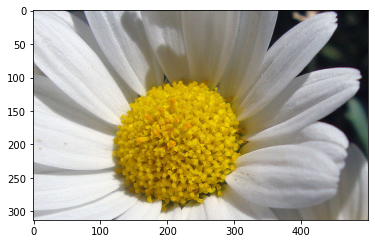

In [ ]:
img,label=dataset[1]

plt.imshow(img)

In [ ]:
import torchvision.transforms as tt
dataset=ImageFolder(data_dir,tt.Compose([tt.Resize(64),
                                         tt.RandomCrop(64),
                                         tt.ToTensor()]))

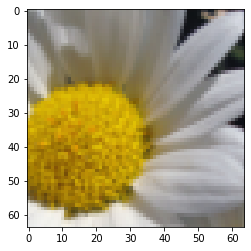

In [ ]:
img,label=dataset[1]

plt.imshow(img.permute(1,2,0))

In [ ]:
val_pct=0.15
val_size=int(val_pct*len(dataset))

train_size=len(dataset)-val_size
train_size,val_size

(3670, 647)

In [ ]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [train_size,val_size])

len(train_ds),len(val_ds)

(3670, 647)

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [ ]:
train_dl = DataLoader(train_ds,
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)
val_dl = DataLoader(val_ds,
                    batch_size*2,
                    num_workers=4, 
                    pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [ ]:
show_batch(train_dl)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for cls in os.listdir(data_dir):
  print(cls,':' ,len(os.listdir(data_dir + '/' + cls)))

# Utility Functions

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
torch.cuda.is_available()

In [ ]:
device = get_default_device()

device

In [ ]:
img, label=dataset[0]

In [ ]:
img

In [ ]:
img.shape

In [ ]:
img.device

In [ ]:
img_gpu=to_device(img,device)

img_gpu.device

In [ ]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)

# Model and training utilities

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):

        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Model

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                        nn.Flatten(), # 128 x 2048
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

In [ ]:
model.conv1[0].weight.device

In [ ]:
torch.cuda.empty_cache()

pass one batch of input tensor through the model

In [ ]:
for batch in train_dl:
  images,labels=batch
  print('images.shape',images.shape)
  print('images.device',images.device)
  preds=model(images)
  print('preds.shape',preds.shape)
  break


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])


# Training

In [ ]:
history = [evaluate(model, val_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.23396027088165283, 'val_loss': 1.6078364849090576}]

In [ ]:
history += fit(7,0.001,model,train_dl,val_dl,torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.4751, val_loss: 1.5359, val_acc: 0.3442
Epoch [1], train_loss: 1.0375, val_loss: 1.0218, val_acc: 0.6233
Epoch [2], train_loss: 0.9022, val_loss: 0.8956, val_acc: 0.6806
Epoch [3], train_loss: 0.7951, val_loss: 0.9137, val_acc: 0.6743
Epoch [4], train_loss: 0.7404, val_loss: 0.8219, val_acc: 0.6973
Epoch [5], train_loss: 0.6774, val_loss: 0.7760, val_acc: 0.7292
Epoch [6], train_loss: 0.5927, val_loss: 0.6634, val_acc: 0.7597


In [ ]:
history += fit(5,0.001,model,train_dl,val_dl,torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.7508, val_loss: 0.6689, val_acc: 0.7595
Epoch [1], train_loss: 0.6256, val_loss: 0.8185, val_acc: 0.7201
Epoch [2], train_loss: 0.5552, val_loss: 0.8021, val_acc: 0.7175
Epoch [3], train_loss: 0.4641, val_loss: 0.5107, val_acc: 0.8144
Epoch [4], train_loss: 0.4272, val_loss: 0.4981, val_acc: 0.8227


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

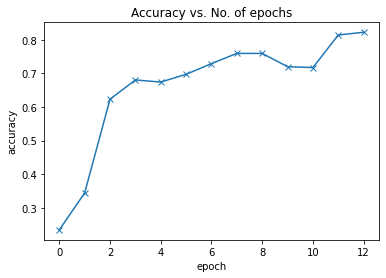

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

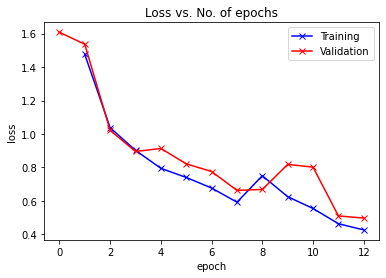

In [ ]:
plot_losses(history)